In [1]:
import warnings
warnings.filterwarnings("ignore")
import pyart
import numpy as np
import xarray as xr
from pyart.retrieve import get_freq_band
from matplotlib import pyplot as plt
import glob, os


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [42]:
files = glob.glob("imd_temp_radar/out/*GOA*B*.nc")
files.sort()
len(files)

2

In [4]:
radar = pyart.io.read_cfradial(files[0])
radar.fields.keys()

dict_keys(['REF', 'VELH', 'WIDTH'])

In [5]:
def plot_radar_raw(radar):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi("REF", vmin=-10., vmax=70., 
                     cmap='pyart_NWSRef', ax=ax1)
    
    display.plot_ppi("VELH", vmin=-35., vmax=35., 
                         cmap='pyart_NWSVel', ax=ax2)

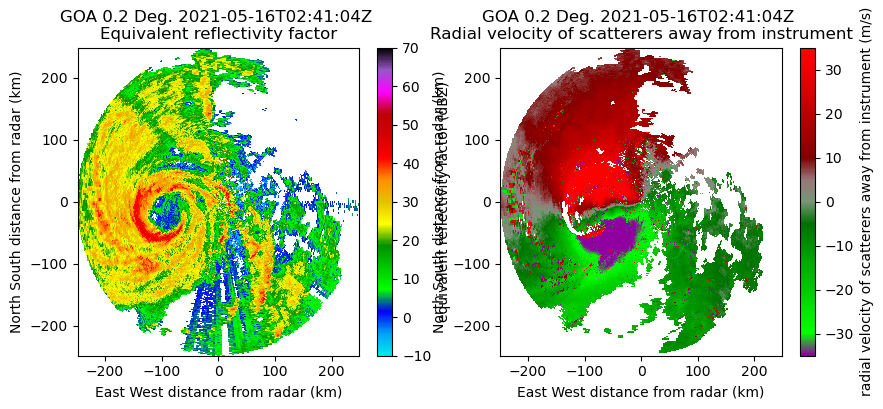

In [6]:
plot_radar_raw(radar)

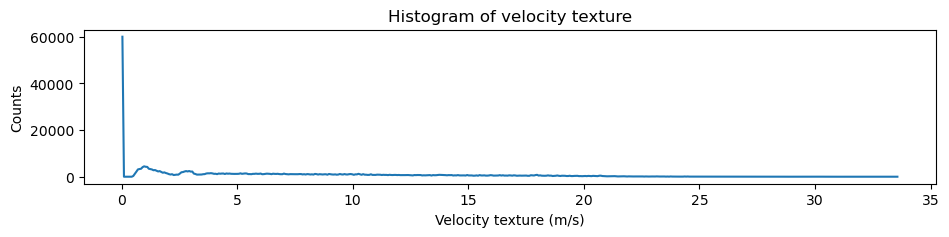

In [7]:
vel_texture = pyart.retrieve.calculate_velocity_texture(
    radar, vel_field="VELH", wind_size=10)
radar.add_field("VT", vel_texture, replace_existing=True)
# Compute histogram of velocity texture field, after removing NaN values
vt_data = radar.fields["VT"]["data"]
vt_data_nonan = vt_data[~np.isnan(vt_data)]
hist, bins = np.histogram(vt_data_nonan, bins=500)

# Plot the histogram
bins = (bins[1:] + bins[:-1]) / 2.0
plt.figure(figsize=[11, 2])
plt.plot(bins, hist)
plt.xlabel("Velocity texture (m/s)")
plt.ylabel("Counts")
plt.title("Histogram of velocity texture")
plt.show()


In [8]:
radar.fields.keys()

dict_keys(['REF', 'VELH', 'WIDTH', 'VT'])

In [9]:
def mask_data(radar, moment, gatefilter, masking=True):
    if masking:
        dsp=pyart.correct.despeckle_field(radar, moment, gatefilter=gatefilter, size= 20)
        mom_masked= np.ma.masked_where(dsp.gate_included == False, radar.fields[moment]['data'])
    else:
        mom_masked=moment
    radar.add_field(moment, {'data':mom_masked}, replace_existing=True)
    return radar

In [10]:
def filter_data(radar, refl_field, vel_field):
    
    texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field=vel_field,
                                                        wind_size=20,
                                                        check_nyq_uniform=False
                                                       )
    radar.add_field('VT',texture,replace_existing=True)
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.include_inside(refl_field, -10, 70)
    gatefilter.exclude_outside(refl_field, -20, 90)
    gatefilter.exclude_above("VT", 20)
    radar = mask_data(radar, refl_field, gatefilter, True)
    radar = mask_data(radar, vel_field, gatefilter, True)
#     gatefilter_ref = pyart.filters.moment_based_gate_filter(radar, ncp_field=ncp_field, min_ncp=ncp_thresh,)
#     radar = mask_data(radar, refl_field, gatefilter_ref, True)
    return radar

In [11]:
radar = filter_data(radar, "REF", "VELH")

In [12]:
def plot_radar(radar):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi("REF", vmin=-10., vmax=70., 
                     cmap='pyart_NWSRef', ax=ax1)
    
    display.plot_ppi("VELH", vmin=-35., vmax=35., 
                         cmap='pyart_NWSVel', ax=ax2)

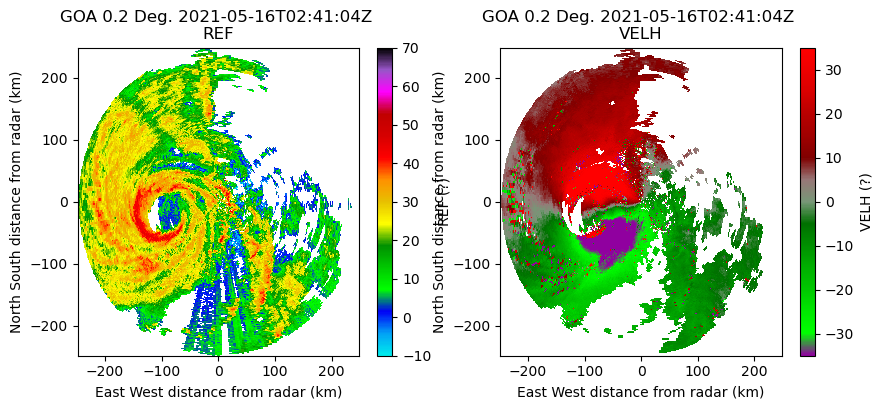

In [13]:
plot_radar(radar)

In [18]:
def dbz2rain(radar, ref_field="REF", a=200.0, b=1.6):
    '''Convert reflectivity to rain mm/h'''
    Z = 10 ** (radar.fields[ref_field]['data']/10)
    rain = (Z / a) ** (1.0 / b)
    rain_dic = {'data' : rain,
                     '_FillValue' : pyart.config.get_fillvalue(),
                     'long_name' : 'Rain Rate',
                     'standard_name' : 'Rain Rate',
                     'units' : 'mm/h'}
    radar.add_field("RAINRATE", rain_dic, True)
    return radar

In [20]:
radar = dbz2rain(radar)

In [21]:
radar.fields.keys()

dict_keys(['REF', 'VELH', 'WIDTH', 'VT', 'RAINRATE'])

In [40]:
def plot_rain_rate(radar):
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi("RAINRATE", vmin = 0, vmax = 50,
                     cmap='jet', ax=ax1)

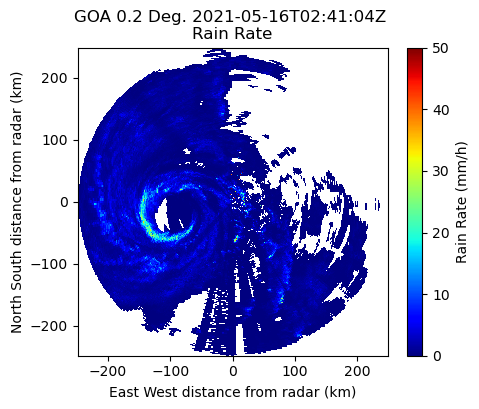

In [41]:
plot_rain_rate(radar)

In [74]:
import pyscancf as pcf

In [85]:
def create_grid(radar, fields=['RAINRATE']):
    xrng = yrng = radar.range['data'].max()
    nxrng = nyrng = -radar.range['data'].max()
    grid = pyart.map.grid_from_radars(radar,(1,400,400),
                       ((0,0),(nxrng, xrng),(nyrng, yrng)), 
                                       weighting_function='Barnes2',
                                      fields=fields,
                                      )
    return grid

200000 m / 400 bins = 500 m resolution

## Let's apply it on whole data

In [86]:
files = glob.glob("imd_temp_radar/out/*GOA*B*.nc")
files.sort()
len(files)

2

In [3]:
# create output directory
# !mkdir imd_temp_radar/out/gridded_rain
out_dir = "imd_temp_radar/out/gridded_rain"

In [89]:
for file in files:
    print(f"Reading: {file}")
    radar = pyart.io.read_cfradial(file)
    radar = filter_data(radar, "REF", "VELH")
    radar = dbz2rain(radar, ref_field='REF', a=200.0, b=1.6)
    grid = create_grid(radar)
    os.system(f'rm -rf {out_dir}{os.sep}grid_{os.path.basename(file)}')
    pyart.io.write_grid(f'{out_dir}{os.sep}grid_{os.path.basename(file)}', grid)
    

Reading: imd_temp_radar/out/cfrad_GOA210516024101-IMD-B.nc
Reading: imd_temp_radar/out/cfrad_GOA210516030244-IMD-B.nc


In [90]:
ls $out_dir

grid_cfrad_GOA210516024101-IMD-B.nc  grid_cfrad_GOA210516030244-IMD-B.nc


In [4]:
def grid2xarray(file):
    grid = pyart.io.read_grid(file)
    xg = grid.to_xarray()
    return xg

In [5]:
gfiles = glob.glob(out_dir+"/grid*nc")
len(gfiles)

2

In [6]:
grid_list = []
for gfile in gfiles:
    grid_list.append(grid2xarray(gfile))

In [7]:
ds = xr.merge(grid_list)

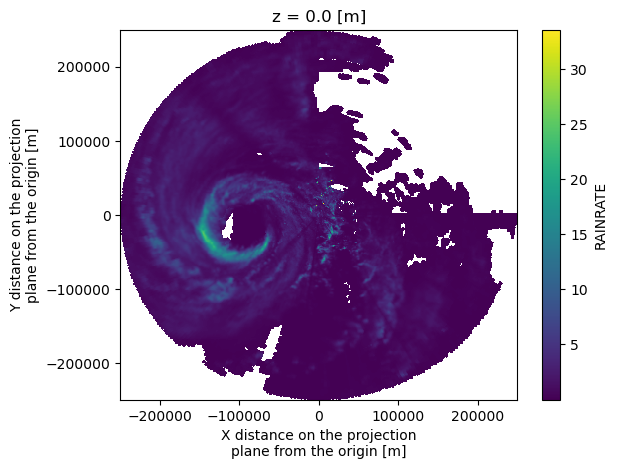

In [8]:
ds['RAINRATE'].mean("time").plot()

In [9]:
dsg = ds.swap_dims({'x':'lon', "y":'lat'})

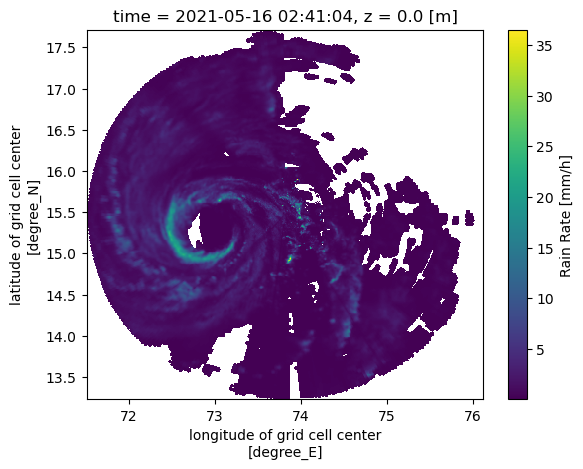

In [10]:
dsg.RAINRATE.isel(time=0).plot()

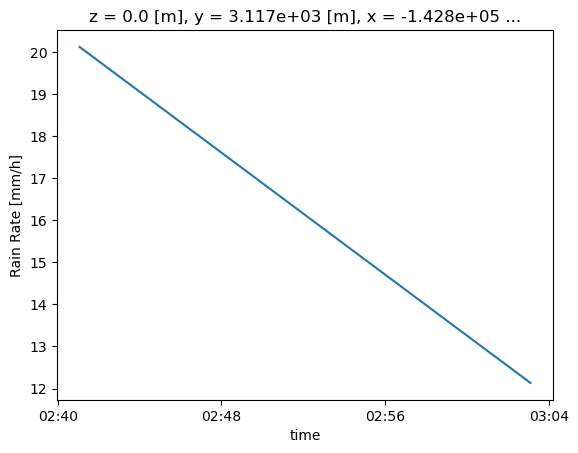

In [11]:
dsg.RAINRATE.sel(lat = 15.5, lon = 72.5, method = "nearest").plot()

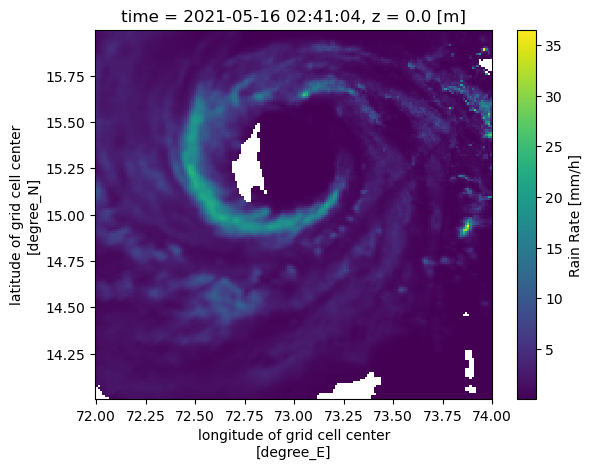

In [15]:
dsg.RAINRATE.sel(lat = slice(14, 16), lon = slice(72, 74)).isel(time=0).plot()

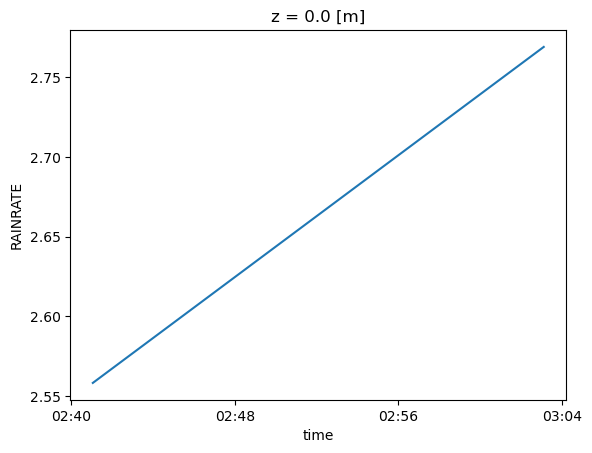

In [20]:
dsg.RAINRATE.sel(lat = slice(14, 16), lon = slice(72, 74)).mean(['lat', 'lon']).plot()

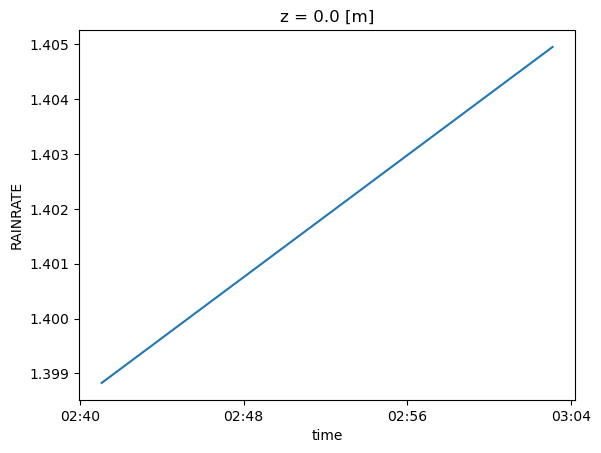

In [21]:
dsg.RAINRATE.mean(['lat', 'lon']).plot()

---

Here are some definitions for the code used in the Jupyter Notebook:

- import: A keyword in Python used to bring in external modules/libraries to use in your code.
- warnings: A built-in Python module that provides functions to issue warnings to the user, which are often used to indicate that something may be incorrect or suboptimal but does not necessarily result in an error.
- pyart: A Python module that provides tools for working with weather radar data, including loading, manipulating, and visualizing radar data.
- numpy: A Python package for scientific computing with arrays, providing support for operations on large, multi-dimensional arrays and matrices.
- xarray: A Python package for working with labeled multi-dimensional arrays, commonly used for working with scientific data.
- pyplot: A sub-module of the matplotlib library for creating static, interactive, and animated visualizations in Python.
- glob: A built-in Python module that provides functions for finding pathnames matching a specified pattern according to the rules used by the Unix shell.
- os: A built-in Python module that provides a way of interacting with the file system.
- plt.subplots: A function in the matplotlib library used to create a figure and a set of subplots.
- pyart.graph.RadarMapDisplay: A class in the Py-ART library that provides tools for plotting radar data on a map.
- pyart.retrieve.calculate_velocity_texture: A function in the Py-ART library that computes the velocity texture of Doppler radar data, which is a measure of the variability of velocity values in a region of interest.
- np.histogram: A function in the NumPy library that computes the histogram of a set of data.
- GateFilter: A class in the Py-ART library that provides tools for filtering radar data based on certain criteria.
- pyart.filters.moment_based_gate_filter: A function in the Py-ART library that filters radar data based on a given moment (e.g., reflectivity or Doppler velocity) and a minimum threshold value for a related parameter (e.g., normalized coherent power).
- pyart.correct.despeckle_field: A function in the Py-ART library that removes speckle noise from a radar data field using a median filter.
- dbz2rain: A function that converts reflectivity data (in dBZ) to rain rate (in mm/h) using the Z-R relationship, which relates radar reflectivity to rainfall rate based on empirical measurements.
- RAINRATE: A field name used to store the estimated rain rate data in the radar object.
- create_grid: A function that creates a 3D Cartesian grid from radar data using the Py-ART and xarray libraries.

warnings.filterwarnings("ignore"): This function is used to ignore warnings that might appear during the execution of the code.

pyart.io.read_cfradial(files[0]): This function reads a radar data file in the CF/Radial format.

plot_radar_raw(radar): This function is used to create a raw radar plot that shows reflectivity and velocity data.

calculate_velocity_texture(radar, vel_field="VELH", wind_size=10): This function calculates the velocity texture of the radar data.

mask_data(radar, moment, gatefilter, masking=True): This function masks a given moment (reflectivity or velocity) in the radar data based on a gate filter.

filter_data(radar, refl_field, vel_field): This function filters the radar data based on reflectivity and velocity data.

plot_radar(radar): This function is used to create a plot that shows filtered reflectivity and velocity data.

dbz2rain(radar, ref_field="REF", a=200.0, b=1.6): This function converts reflectivity data to rain rate.

plot_rain_rate(radar): This function is used to create a plot that shows rain rate data.

create_grid(radar, fields=['RAINRATE']): This function creates a grid from the radar data.